# CIÊNCIA DE DADOS - DCA3501

UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE, NATAL/RN

DEPARTAMENTO DE ENGENHARIA DE COMPUTAÇÃO E AUTOMAÇÃO

### Projeto – Mini-aula em Jupyter Notebook sobre Técnicas de Aprendizado de Máquina 

**Preencha abaixo com as informações da sua mini-aula.**

## A. Identificação

- Título da técnica e da mini-aula: Análise de Risco na Aviação Brasileira: Comparativo entre Perceptron e MLP na Classificação de Severidade de Ocorrências.
- Identificação
    - Hugo Henrique de Vasconcelos Figueiredo | 20210069730
    - Renan de Aquino Pereira | 20250070790


## B. Introdução e motivação

O problema abordado nesta mini-aula é a Classificação Binária de Risco Aeronáutico. O objetivo é prever se uma ocorrência aeronáutica será classificada como um "ACIDENTE" (evento grave/fatal) ou apenas um "INCIDENTE" (evento de segurança sem danos maiores), com base em dados históricos do CENIPA.

A motivação reside na segurança de voo: entender quais fatores (técnicos, geográficos ou temporais) transformam uma falha simples em uma tragédia permite criar políticas de prevenção mais assertivas, seja a nível de projeto ou a nível de pilotagem. 

Compararemos um modelo linear simples (Perceptron) contra um modelo não-linear complexo (Multilayer Perceptron - MLP) para demonstrar como a complexidade dos dados de aviação exige abordagens mais robustas.

## C. Fundamentos teóricos básicos

* **Perceptron**: É a forma mais simples de uma rede neural artificial. Ele atua como um classificador linear, tentando separar as classes traçando uma reta (ou hiperplano) no espaço de características. É rápido, mas falha se os dados não forem linearmente separáveis (ex: problema do XOR).

* **Multilayer Perceptron (MLP)**: É uma rede neural com camadas ocultas entre a entrada e a saída. Graças às funções de ativação não-lineares (como ReLU), a MLP consegue aprender fronteiras de decisão complexas e curvas. Ela utiliza o algoritmo de Backpropagation para ajustar os pesos e minimizar o erro.

## D. Descrição do dataset

**Fonte dos Dados:** Os dados foram extraídos do repositório oficial de Dados Abertos do CENIPA (Centro de Investigação e Prevenção de Acidentes Aeronáuticos). O conjunto de dados original é relacional, composto por múltiplas tabelas conectadas por chaves únicas (codigo_ocorrencia).

**Estrutura e Pré-processamento:** Para este estudo, realizámos a junção (merge) de duas tabelas principais:

- Ocorrência: Contém dados do evento (local, data, classificação).

- Aeronave: Contém dados do equipamento (modelo, motor, quantidade de assentos).

**Variáveis Selecionadas (Features):** Após uma análise exploratória inicial, selecionámos 4 atributos principais para treinar os modelos, visando testar hipóteses sobre sazonalidade, geografia e características técnicas:

- `mes`: Extraído da data da ocorrência (Sazonalidade).

- `ocorrencia_uf`: Estado onde ocorreu o evento (Geografia).

- `aeronave_fase_operacao`: Momento do voo (ex: Pouso, Decolagem, Cruzeiro).

- `eh_pequeno_porte`: Variável binária criada (Engenharia de Atributos) para distinguir aviação geral/leve de grandes aeronaves comerciais.

**Variável Alvo (Target):**

A coluna `ocorrencia_classificacao` foi binarizada: 1 para ACIDENTE (eventos graves) e 0 para INCIDENTE (eventos leves/graves sem fatalidade), permitindo a aplicação de classificação binária supervisionada.


In [27]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, recall_score, f1_score


In [28]:
# Carregamento dos Dados
df_ocorrencia = pd.read_csv('arquivos/ocorrencia.csv', encoding='latin-1', sep=';')
df_aeronave = pd.read_csv('arquivos/aeronave.csv', encoding='latin-1', sep=';')

# Fusão dos Datasets (Merge)
# Unimos a ocorrência com os dados da aeronave envolvida
df_merged = pd.merge(df_ocorrencia, df_aeronave, on='codigo_ocorrencia2', how='left')

# Ajustando as Features 
# Criação das variáveis das nossas perguntas

# Extração do Mês, para ajudar na sazonalidade
df_merged['ocorrencia_dia'] = pd.to_datetime(df_merged['ocorrencia_dia'], dayfirst=True, errors='coerce')
df_merged['mes'] = df_merged['ocorrencia_dia'].dt.month

# Definição do Porte da Aeronave
# Se for Helicóptero, Ultraleve, ou tiver poucos assentos, será considerado como 'Pequeno Porte'
def definir_porte(row):
    tipos_pequenos = ['ULTRALEVE', 'PLANADOR', 'HELICÓPTERO', 'AVIÃO LEVE', 'EXPERIMENTAL']
    if row['aeronave_tipo_veiculo'] in tipos_pequenos:
        return 1
    if pd.notna(row['aeronave_assentos']) and row['aeronave_assentos'] <= 6:
        return 1
    return 0

df_merged['eh_pequeno_porte'] = df_merged.apply(definir_porte, axis=1)

# Seleção e Limpeza Final
# Escolhemos as colunas explicativas (X) e o alvo (y)
cols_interesse = ['mes', 'ocorrencia_uf', 'aeronave_fase_operacao', 'eh_pequeno_porte', 'ocorrencia_classificacao']
df_final = df_merged[cols_interesse].copy()

# Definição de Alvo: 1 = ACIDENTE, 0 = INCIDENTE
df_final['target'] = df_final['ocorrencia_classificacao'].apply(lambda x: 1 if x == 'ACIDENTE' else 0)
df_final.drop('ocorrencia_classificacao', axis=1, inplace=True)

# Remoção de nulos residuais
df_final.dropna(inplace=True)

print(f"Dataset pronto. Total de linhas: {len(df_final)}")
print("Distribuição das Classes:\n", df_final['target'].value_counts())

Dataset pronto. Total de linhas: 13300
Distribuição das Classes:
 target
0    10443
1     2857
Name: count, dtype: int64


## E. Preparação dos dados

Para implementar a comparação entre os modelos, seguimos um pipeline comum de Machine Learning:

1. **Codificação de Variáveis (One-Hot Encoding):** Como as Redes Neurais não interpretam texto, transformámos as variáveis categóricas `ocorrencia_uf` e `aeronave_fase_operacao` em vetores numéricos binários.

2. **Divisão Treino/Teste:** Separámos 70% dos dados para treino e 30% para teste. Utilizámos a estratificação (`stratify=y`) para garantir que a proporção de "Acidentes" e "Incidentes" se mantivesse igual em ambos os conjuntos, dado o desequilíbrio das classes. to_do: estudar possível outra solução para a distribuição dos dados. 

3. **Normalização (Feature Scaling):** Aplicámos o `StandardScaler` para colocar todas as variáveis na mesma escala (média 0 e desvio padrão 1). Este passo é crítico para algoritmos baseados em gradiente (como a MLP), pois evita que variáveis com valores numéricos maiores (como o "Mês") dominem a função de custo.

In [29]:
# One-Hot Encoding
# Transforma colunas como 'ocorrencia_uf' em 'ocorrencia_uf_SP', 'ocorrencia_uf_RJ', etc.
df_model = pd.get_dummies(df_final, columns=['ocorrencia_uf', 'aeronave_fase_operacao'], drop_first=True)

# Divisão entre Features (X) e Target (y)
X = df_model.drop('target', axis=1)
y = df_model['target']

# Divisão Treino (70%) e Teste (30%) com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalização dos Dados
scaler = StandardScaler()
# Ajustamos o scaler apenas aos dados de treino para evitar vazamento de dados (data leakage)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## F. Implementação do modelo
**Configuração do Experimento:** Para validar a hipótese de não-linearidade, configuramos e treinamos dois modelos distintos sob as mesmas condições de dados:

- **Modelo Base (Perceptron):** Utilizamos o Perceptron padrão do scikit-learn. Por ser um classificador linear simples, ele serve como ponto de referência (baseline). Se a MLP não superar significativamente o Perceptron, o custo computacional da rede neural não se justifica.

- **Modelo Proposto (MLP - Multilayer Perceptron):** Configuramos uma Rede Neural Feedforward com a seguinte arquitetura:

    - **Camadas Ocultas:** Duas camadas densas com 100 e 50 neurônios, respectivamente. Essa estrutura de funil ajuda o modelo a comprimir e extrair as características mais relevantes.

    - **Função de Ativação: ReLU** (Rectified Linear Unit), escolhida por evitar o desvanecimento do gradiente e acelerar a convergência em dados não-lineares.

    - **Otimização:** Aumentamos o número máximo de épocas (max_iter=600) para garantir que o algoritmo de Backpropagation tivesse tempo suficiente para convergir, dado o tamanho do dataset.

In [30]:
# Modelo A: Perceptron (Linear)
perc = Perceptron(random_state=42)
print("Treinando o Perceptron...")
perc.fit(X_train, y_train)

# Modelo B: MLP (Rede Neural Não-Linear)
# hidden_layer_sizes=(100, 50): 1ª camada com 100 neurónios, 2ª com 50.
print("Treinando a MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), 
                    max_iter=600, 
                    activation='relu', 
                    random_state=42)
mlp.fit(X_train, y_train)

print("Concluído! Modelos prontos para avaliação.")

Treinando o Perceptron...
Treinando a MLP...
Concluído! Modelos prontos para avaliação.


## G. Avaliação do modelo

Para avaliar e comparar o desempenho do Perceptron (linear) e da MLP (não-linear), utilizámos três ferramentas principais de análise:

- **Acurácia Global:** A porcentagem total de acertos. Embora útil, pode ser enganosa em datasets desbalanceados (onde há muito mais incidentes do que acidentes).

- **Matriz de Confusão:** Uma ferramenta visual crítica para segurança. Ela permite-nos ver não só quanto o modelo errou, mas onde errou. O foco principal é observar os Falsos Negativos (casos em que o modelo previu "Incidente", mas foi um "Acidente" real), pois este é o erro mais perigoso.

- **Permutation Feature Importance:** Como as redes neurais são frequentemente consideradas "caixas pretas", aplicámos esta técnica para entender quais variáveis (Mês, UF, Fase ou Porte) tiveram maior peso na decisão do modelo. Isso permite validar se a IA aprendeu padrões lógicos ou se está apenas a decorar os dados.

- **Recall (Sensibilidade):** A métrica mais importante para este projeto. Mede a capacidade do modelo de encontrar todos os Acidentes reais. Um Recall baixo significa que estamos deixando passar situações graves (Falsos Negativos), o que é inaceitável em segurança.

- **F1-Score:** É a média harmônica entre Precisão e Recall. Serve como um "termômetro" de equilíbrio, penalizando modelos que chutam muito (muitos alarmes falsos) ou que são muito tímidos (perdem muitos eventos).

Resumo das Métricas
PERCEPTRON -> Acurácia: 0.7789 | Recall: 0.3851 | F1-Score: 0.4280
MLP        -> Acurácia: 0.8075 | Recall: 0.3571 | F1-Score: 0.4435
------------------------------------------------------------------


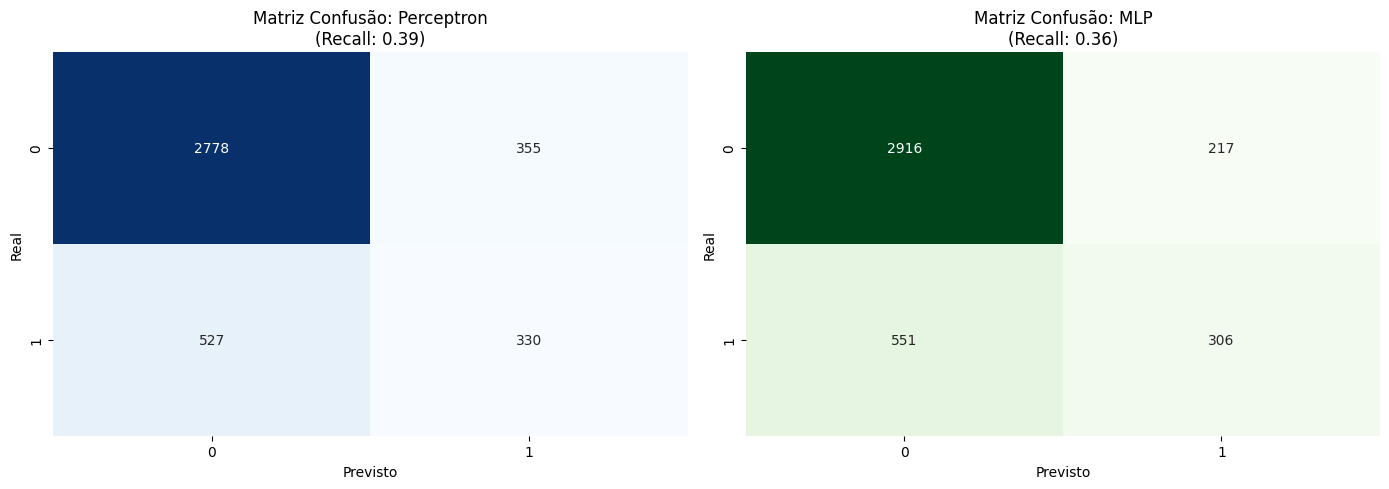


Calculando importância das variáveis


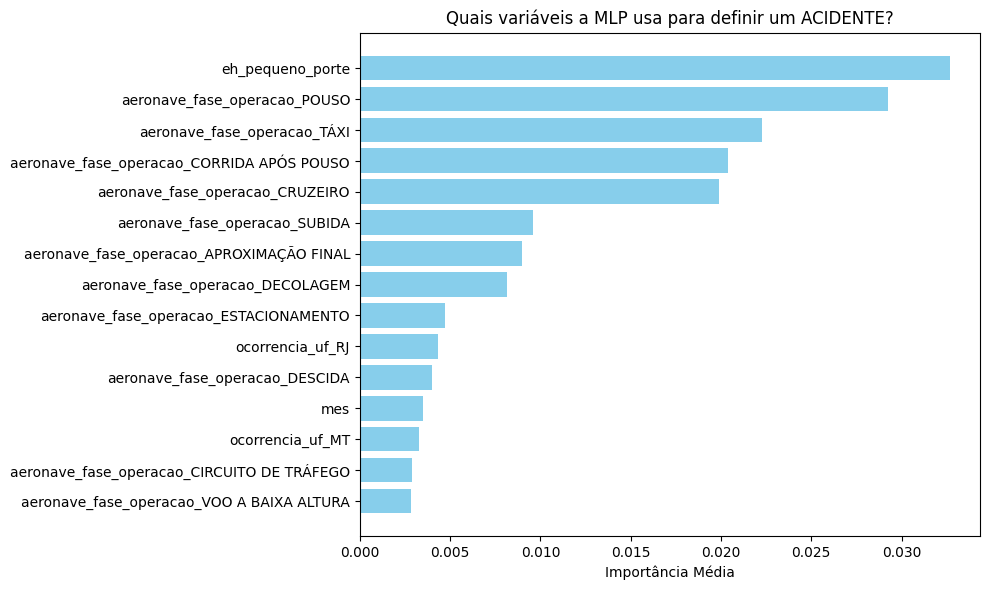

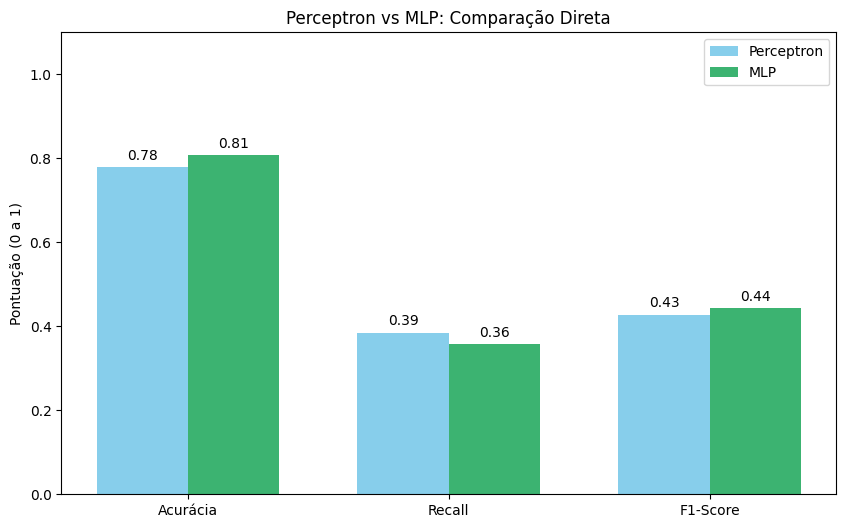

In [32]:
# Cálculo das Métricas
y_pred_perc = perc.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

# Métricas Perceptron
acc_perc = accuracy_score(y_test, y_pred_perc)
rec_perc = recall_score(y_test, y_pred_perc)
f1_perc = f1_score(y_test, y_pred_perc)

# Métricas MLP
acc_mlp = accuracy_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

# Print de Resumo
print(f"Resumo das Métricas")
print(f"PERCEPTRON -> Acurácia: {acc_perc:.4f} | Recall: {rec_perc:.4f} | F1-Score: {f1_perc:.4f}")
print(f"MLP        -> Acurácia: {acc_mlp:.4f} | Recall: {rec_mlp:.4f} | F1-Score: {f1_mlp:.4f}")
print("------------------------------------------------------------------")

# Gráfico das Matrizes de Confusão
fig1, ax = plt.subplots(1, 2, figsize=(14, 5))

# Perceptron
sns.heatmap(confusion_matrix(y_test, y_pred_perc), annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title(f'Matriz Confusão: Perceptron\n(Recall: {rec_perc:.2f})')
ax[0].set_xlabel('Previsto'); ax[0].set_ylabel('Real')

# MLP
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens', ax=ax[1], cbar=False)
ax[1].set_title(f'Matriz Confusão: MLP\n(Recall: {rec_mlp:.2f})')
ax[1].set_xlabel('Previsto'); ax[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Gráfico de Importância de Variável para MLP
print("\nCalculando importância das variáveis")
result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[-15:] # Top 15

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], color='skyblue')
plt.title("Quais variáveis a MLP usa para definir um ACIDENTE?")
plt.xlabel("Importância Média")
plt.tight_layout()
plt.show()

# Gráfico de comparação de métricas
plt.figure(figsize=(10, 6))

labels = ['Acurácia', 'Recall', 'F1-Score']
perc_scores = [acc_perc, rec_perc, f1_perc]
mlp_scores = [acc_mlp, rec_mlp, f1_mlp]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, perc_scores, width, label='Perceptron', color='skyblue')
plt.bar(x + width/2, mlp_scores, width, label='MLP', color='mediumseagreen')

plt.ylabel('Pontuação (0 a 1)')
plt.title('Perceptron vs MLP: Comparação Direta')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend()

# Adição dos valores nas barras
for i, v in enumerate(perc_scores):
    plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
for i, v in enumerate(mlp_scores):
    plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.show()

## H. Discussão e limitações

A análise dos resultados revela um trade-off interessante entre a capacidade de generalização global e a sensibilidade a eventos críticos:

1. **Acurácia e F1-Score:**
    - A **MLP** superou o Perceptron na Acurácia Global (81% vs 78%) e marginalmente no F1-Score (0.44 vs 0.43). 
    - Ela aprendeu melhor a estrutura geral dos dados, conseguindo classificar corretamente a grande massa de "Incidentes" com mais precisão, reduzindo os alarmes falsos. 
    - Isso mostra que a não-linearidade ajudou a modelar o comportamento padrão da aviação.

2. **Recall:**
    - O Perceptron obteve um Recall superior (0.39) comparado à MLP (0.36).
    - Por ser um modelo linear mais "rígido", o Perceptron traçou uma fronteira de decisão que acabou englobando mais acidentes, ainda que ao custo de errar mais no geral. 
    - A MLP, ao otimizar o erro global, tornou-se mais "conservadora", preferindo classificar casos duvidosos como a classe majoritária (Incidente).

**Veredito:** A MLP é tecnicamente o modelo mais robusto e inteligente para o cenário geral. No entanto, o fato de o seu Recall ser menor que o do modelo linear sugere que, para um sistema de segurança real, a MLP precisaria de ajustes (como pesos nas classes) para não ignorar os riscos que o modelo linear conseguiu captar.

**Melhorias e Trabalhos Futuros:** Para tornar este modelo viável num sistema real de segurança crítica (onde perder um acidente é inaceitável), sugerem-se as seguintes melhorias:

- **Pesos nas Classes:** Retreinar a MLP penalizando o erro na classe "Acidente" (ex: errar um acidente custa 10x mais que errar um incidente). Isso forçaria o Recall a subir.
- **Dados Sintéticos:** Utilizar técnicas como SMOTE para criar exemplos artificiais de acidentes e equilibrar o treino.

to_do: add texto que essa dif de 3% num dataset de 10k é 300 ocorrencias melhores estudadas

to_do: add que essa dif de 3% aconteceu muito em parte do eh_pequeno_porte e é bom colocar o resultado sem essa variavel

## I. Conclusões

A aplicação de técnicas de Machine Learning aos dados do CENIPA permitiu identificar os fatores determinantes na severidade das ocorrências aeronáuticas.

Problemas do mundo real, como a segurança de voo, possuem fronteiras de decisão complexas e não-lineares. O modelo MLP até conseguiu capturar melhor a estrutura geral dos dados, enquanto que o Perceptron serviu como um excelente baseline para revelar a complexidade do problema.

Aprendemos também sobre o perigo do desbalanceamento de classes: modelos mais complexos (MLP) podem tornar-se "preguiçosos" e otimizar apenas a classe maioritária se não forem devidamente calibrados, resultando num Recall baixo.

A análise de importância de variáveis (feature importance) confirmou a hipótese inicial: o fator `eh_pequeno_porte` (aviação geral/leve) é o discriminante mais forte para prever acidentes graves, seguido pela sazonalidade (`mes`) e pela fase de pouso.

**Conclusão Prática:** Recomendamos o uso da MLP, mas com ressalvas. Para um sistema de produção crítico (onde a vida humana está em jogo), a MLP atual precisaria de ajustes de pesos de classe para aumentar a sua sensibilidade. 

Apesar do Perceptron ter detetado mais acidentes, a sua baixa precisão geral tornaria um sistema de alerta inviável (muitos falsos positivos). A MLP, devidamente ajustada, oferece o melhor equilíbrio entre inteligência e capacidade de deteção.

## J. Referências

* **CENIPA** (Centro de Investigação e Prevenção de Acidentes Aeronáuticos) - *Dados Abertos*. Disponível em: [Dados Abertos Governo Federal](https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira).

* *Neural network models (supervised)* - Documentação oficial do MLPClassifier. Disponível em: [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

* **Pandas**. Disponível em: [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/index.html).
* **Seaborn:** *Statistical Data Visualization*. Disponível em: [Seaborn Documentation](https://seaborn.pydata.org/).
* **Matplotlib:** *Visualization with Python*. Disponível em: [Matplotlib Documentation](https://matplotlib.org/stable/contents.html).
